<a href="https://colab.research.google.com/github/Sivadhanushi/Console/blob/main/Image_processing_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

In [2]:
def load_and_process_image(image_path):
    img = load_img(image_path)
    # convert image to array
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

In [3]:
def deprocess(img):
    # perform the inverse of the pre processing step
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # convert RGB to BGR
    img = img[:, :, ::-1]

    img = np.clip(img, 0, 255).astype('uint8')
    return img


def display_image(image):
    # remove one dimension if image has 4 dimension
    if len(image.shape) == 4:
        img = np.squeeze(image, axis=0)

    img = deprocess(img)

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

In [4]:
model = VGG19(
    include_top=False,
    weights='imagenet'
)
# set training to False
model.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


In [5]:
content_layer = 'block5_conv2'
content_model = Model(
    inputs=model.input,
    outputs=model.get_layer(content_layer).output
)

In [6]:
style_layers = [
    'block1_conv1',
    'block3_conv1',
    'block5_conv1'
]
style_models = [Model(inputs=model.input,
                      outputs=model.get_layer(layer).output) for layer in style_layers]

In [7]:
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

In [9]:
def content_loss(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    loss = tf.reduce_mean(tf.square(a_C - a_G))
    return loss

In [8]:
weight_of_layer = 1. / len(style_models)
# style loss
def style_cost(style, generated):
    J_style = 0

    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += current_cost * weight_of_layer

    return J_style


In [10]:
# training function
generated_images = []


def training_loop(content_path, style_path, iterations=50, a=10, b=1000):
	# load content and style images from their respective path
	content = load_and_process_image(content_path)
	style = load_and_process_image(style_path)
	generated = tf.Variable(content, dtype=tf.float32)

	opt = tf.keras.optimizers.Adam(learning_rate=7)

	best_cost = 99999999999999
	best_image = None
	for i in range(iterations):
		with tf.GradientTape() as tape:
			J_content = content_loss(content, generated)
			J_style = style_cost(style, generated)
			J_total = a * J_content + b * J_style

		grads = tape.gradient(J_total, generated)
		opt.apply_gradients([(grads, generated)])

		if J_total < best_cost:
			best_cost = J_total
			best_image = generated.numpy()

		print("Iteration :{}".format(i))
		print('Total Loss {:e}.'.format(J_total))
		generated_images.append(generated.numpy())

	return best_image

In [11]:
# Train the model and get best image
final_img = training_loop('/content/europeanbuilding.jpeg','/content/starrnightt.jpeg')

Iteration :0
Total Loss 1.051186e+11.
Iteration :1
Total Loss 3.774281e+10.
Iteration :2
Total Loss 2.374859e+10.
Iteration :3
Total Loss 2.307697e+10.
Iteration :4
Total Loss 1.659196e+10.
Iteration :5
Total Loss 1.275667e+10.
Iteration :6
Total Loss 1.088987e+10.
Iteration :7
Total Loss 9.573728e+09.
Iteration :8
Total Loss 8.739650e+09.
Iteration :9
Total Loss 7.483993e+09.
Iteration :10
Total Loss 6.144291e+09.
Iteration :11
Total Loss 5.540191e+09.
Iteration :12
Total Loss 5.193852e+09.
Iteration :13
Total Loss 4.748994e+09.
Iteration :14
Total Loss 4.275767e+09.
Iteration :15
Total Loss 3.881258e+09.
Iteration :16
Total Loss 3.643220e+09.
Iteration :17
Total Loss 3.429657e+09.
Iteration :18
Total Loss 3.086746e+09.
Iteration :19
Total Loss 2.788376e+09.
Iteration :20
Total Loss 2.642957e+09.
Iteration :21
Total Loss 2.479697e+09.
Iteration :22
Total Loss 2.285037e+09.
Iteration :23
Total Loss 2.148227e+09.
Iteration :24
Total Loss 2.037293e+09.
Iteration :25
Total Loss 1.953051e+

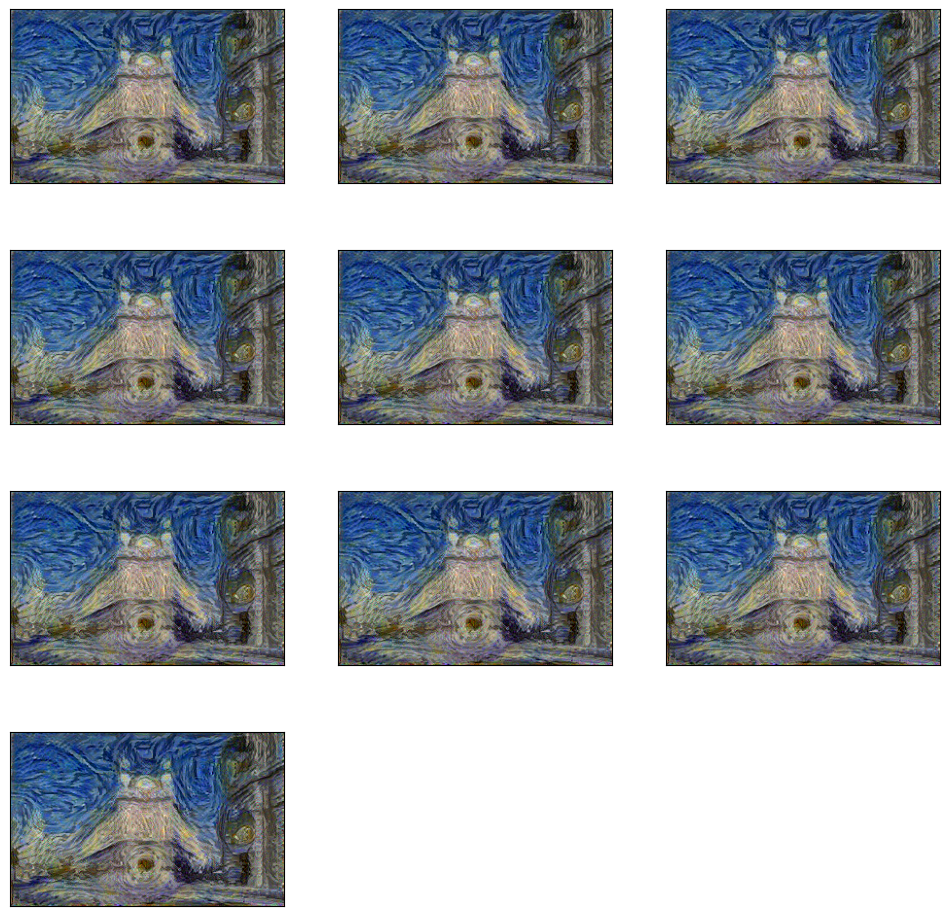

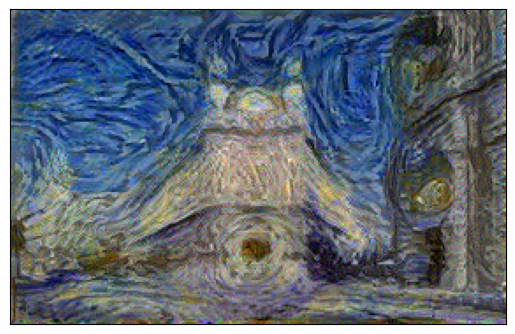

In [12]:
# code to display best generated image and last 10 intermediate results
plt.figure(figsize=(12, 12))

for i in range(10):
	plt.subplot(4, 3, i + 1)
	display_image(generated_images[i+39])
plt.show()

# plot best result
display_image(final_img)